In [21]:
import sys
sys.path.append("..") # import one subdirectory up in files
#sys.path.append("..") # import one subdirectory up in files
#os.chdir("../holopy/")

# standard imports
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import matplotlib
import time as time
#import json
import pickle

# 3rd party packages
import qiskit as qk
import qiskit.providers.aer.noise as noise
import tenpy as tp

## custom things
from networks.networks import IsoMPS
from networks.isonetwork import QKParamCircuit
import circuits.basic_circuits as circuits

In [22]:
## TENPY FUNCTION DEFINITIONS ##
def xxz_mpo(J=1.0, Delta=1.0, hz=0.0, N=1, bc='infinite'):
    site = tp.networks.site.SpinHalfSite(None)
    Id, Sp, Sm, Sz = site.Id, site.Sp, site.Sm, 2*site.Sz
    W_bulk = [[Id, Sp, Sm, Sz, -hz * Sz],
              [None, None, None, None, 0.5 * J * Sm],
              [None, None, None, None, 0.5 * J * Sp],
              [None, None, None, None, J * Delta * Sz],
              [None, None, None, None, Id]]
    H = tp.networks.mpo.MPO.from_grids([site], [W_bulk], bc, IdL=0, IdR=-1) # (probably leave the IdL,IdR)
    return H

# tenpy energy calculator
def energy_tp(param_vals,*args):
    """
    function to calculate energy using MPO/MPS contraction in tenpy
    inputs:
        - param_vals = dict {parameter:value}
        - *args, 
            args[0] should be psi: state as IsoMPS
            args[1] should be H_mpo: Hamiltonian as MPO
        (input made this way to be compatible w/ scipy.optimize)
    outputs:
        - float, <psi|H|psi> computed w/ tenpy
    """
    # parse inputs
    psi=args[0] # state as isoMPS    
    H_mpo = args[1] # Hamiltonian as tenpy MPO
    param_dict = dict(zip(psi.param_list,param_vals))
    
    # convert state from holoPy isoMPS to tenpy MPS
    psi_tp = psi.to_tenpy(param_dict,L=np.inf)
    
    # compute energy
    E = (H_mpo.expectation_value(psi_tp)).real
    return E

In [42]:
## HYPERPARAMETERS ##
# model (xxz)
J = 1.0 # spin-exchange
Delta = 1.0 # Ising-anisotropy
hz = 0.0 # z-field

# ansatz parameters
nb = 1 # number of bond-qubits 
L = 1 # number of unit cells
l_uc = 2 # number of sites in unit cell
n_site_param = 2*nb # number of circuit parameters per site
# number of bond circuit parameters
use_bond_prep = False

if use_bond_prep:
    if nb==1: n_bond_params=3
    elif nb==2: n_bond_params=15 
else:
    n_bond_params=0 

In [55]:
## CREATE ISOMPS FROM PARAMETERIZED CIRCUIT ANSATZ ##
# initialize registers
preg = qk.QuantumRegister(1,'p') # physical qubits
breg = qk.QuantumRegister(nb,'b') # bond qubits
#creg = qk.ClassicalRegister(L*l_uc+nb,'m') # classical register to hold measurement outcomes

## Bond-state prep-circuit ##
bond_prep_params = [qk.circuit.Parameter('bp_'+str(j)) 
                    for j in range(n_bond_params)]
bond_prep_circ = qk.QuantumCircuit(breg)
if use_bond_prep:
    if nb==1: circuits.add_1q_circ(bond_prep_circ, breg[0], bond_prep_params) 
    elif nb==2: circuits.add_su4_circ(bond_prep_circ, breg[0],breg[1], bond_prep_params) 
else:
    bond_prep_circ.h(breg)

# turn into custom parameterized circuit object
bond_prep_pcirc = QKParamCircuit(bond_prep_circ,bond_prep_params)


## Site Circuits ##
# create list of circuits, one for each site in the unit cell (uc)
site_circs = [qk.QuantumCircuit(preg,breg) for j in range(l_uc)]
# create a list of parameter-lists, (one list of parameters per site in uc)
site_circ_params = [[qk.circuit.Parameter('s'+str(j)+'_'+str(k))
                     for k in range(n_site_param)] 
                    for j in range(l_uc)]
site_pcircs=[] # list of QKParamCirc's for each site in uc
for j in range(l_uc):
    if j%2==0: site_circs[j].x(preg[0]) # alternating 10101010... for physical qubit
    
    # star circuit of xxz-type 2-qubit gates
    for k in range(nb): 
        circuits.add_xxz_circ(site_circs[j], 
                              preg[0], breg[k], 
                              site_circ_params[j][2*k:2*(k+1)])
    # combine into parameterized circuit
    site_pcircs += [QKParamCircuit(site_circs[j], site_circ_params[j])]

# create holopy isoMPS
psi = IsoMPS(preg,breg,site_pcircs,boundary_circuit=bond_prep_pcirc,L=1)

print('circuits for each site in uc:')
for j in range(l_uc):
    site_circs[j].draw('mpl')

circuits for each site in uc:


In [57]:
## OPTIMIZE CIRCUIT PARAMETERS CLASSICALLY IN TENPY ##
# create tenpy mpo
H_mpo = xxz_mpo(J=J,hz=hz,Delta=Delta,N=1)


x0 = np.pi*np.random.randn(psi.n_params) # starting point for parameters
t0 = time.time()
opt_result = minimize(energy_tp, # function to minimize
                      x0, # starting point for parameters 
                      args=(psi,H_mpo), # must take form (isoMPS,tenpy MPO, Length)
                      method='BFGS'
                     )
tf = time.time()
# set parameters to previously optimized values
opt_vals = opt_result.x
opt_params = dict(zip(psi.param_list,opt_vals))
E_gs_tp = opt_result.fun
print('Optimization done, elapsed time: {}'.format(tf-t0))
print('Optimized energy = {}'.format(E_gs_tp))
print('Optimized parameters')
print(opt_params)

/Users/acpotter/anaconda3/envs/tenpy/lib/python3.9/site-packages/tenpy/networks/mps.py:2588: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/Users/acpotter/anaconda3/envs/tenpy/lib/python3.9/site-packages/tenpy/networks/mps.py:2588: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/Users/acpotter/anaconda3/envs/tenpy/lib/python3.9/site-packages/tenpy/networks/mps.py:2588: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)
/Users/acpotter/anaconda3/envs/tenpy/lib/python3.9/site-packages/tenpy/networks/mps.py:2588: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


Optimization done, elapsed time: 4.062586784362793
Optimized energy = -1.499999999999999
Optimized parameters
{Parameter(s0_0): -2.3561945270372484, Parameter(s0_1): -2.458583188459927, Parameter(s1_0): 1.5707963013016142, Parameter(s1_1): -1.321772779563644e-08}


/Users/acpotter/anaconda3/envs/tenpy/lib/python3.9/site-packages/tenpy/networks/mps.py:2588: UserWarning: canonical_form_infinite: project to smaller bond dimension
  Gl, Wr = self._canonical_form_correct_left(i1, Gl, Wr)


In [46]:
## POSTPROCESSING FUNCTIONS ##
def counts_to_correlators(counts,shots):
    """
    converts qiskit-style counts result 
    to NxN numpy array of 2-point correlatrs
    w/ N = # of sites in isoMPS = L*l_uc
    """
    # number of sites (compute from input dictionary shape)
    N = len(list(counts.keys())[0].split(" ")) 
    C = np.zeros((N,N))
    # loop over each measurement outcome
    for k in counts.keys(): 
        split_list = k.split(" ")[::-1] # split bits from each register
        # note that qiskit typically orders in reverse order 
        # NOTE: WILL NEED TO REVISIT CREG ORDERING IF WE HAVE OTHER CREGs
        
        # compute up all pairs of correlators
        for x in range(N):
            for y in range(x+1,N): # use symmetry C[x,y]=C[y,x] to only compute 1/2 of entries
               C[x,y] += counts[k] * (2.0*(split_list[x]==split_list[y])-1.0)
    C /= shots # normalize
    C += C.T + np.eye(N) # we've constructed only the upper-right triangular part
    return C

def counts_to_mean(counts,shots):
    """
    converts qiskit-type counts result to 
    one point correlator (mean spin component)
    on each site
    """
    N = len(list(counts.keys())[0].split(" "))
    m = np.zeros(N)
    for k in counts.keys(): 
        split_array = np.array(k.split(" ")[::-1]) # split bits from each register
        m += 2.0*(split_array=='1')-1.0
    m /= shots
    return m

In [47]:
## QISKIT SIMULATION ##
L=40 # length of chain to simulate
shots = 400 # number of shots for each measurement

# list of Pauli strings to measure
# example format for L = 3, l_uc = 4: [['xxxy'],['zzzz'],['yzxz']]
measurement_strings = [['x'*l_uc]*L,
                       ['y'*l_uc]*L,
                       ['z'*l_uc]*L] 

# Create meta-data
model_data = {'type':'xxz',
              'J':J,
              'Delta':Delta,
              'hz':hz,
              'L':L,
              'shots':shots,
             }
vqe_data = {'architecture':'su4_star',
                'nb':nb,
                'params':opt_params}

## Define Noise Model ##
# errors (simulation)
perr_1q = 0.000 # 1-qubit gate error
perr_2q = 0.00 # 2-qubit gate error
# depolarizaing errors
depol_1q = noise.depolarizing_error(perr_1q, 1)
depol_2q = noise.depolarizing_error(perr_2q, 2)
noise_model = noise.NoiseModel()
noise_model.add_all_qubit_quantum_error(depol_1q, ['u1', 'u2', 'u3'])
noise_model.add_all_qubit_quantum_error(depol_2q, ['cx','cz'])

In [48]:
# loop through measurement strings, and create list of jobs to run
jobs = []
for m in measurement_strings:
    psi_curr = IsoMPS(preg,breg,
                      site_pcircs,
                      boundary_circuit=bond_prep_pcirc,
                     L=L,
                     bases=m)
    circ_curr = psi_curr.construct_circuit(opt_params)
    jobs += [{'name':'xxz_xxzstar_hz{}'.format(hz)+'_basis_'+m[0],
              'isoMPS':psi_curr,
              'vqe_data':vqe_data,
              'qiskit_circuit':circ_curr,
              'qasm':circ_curr.qasm(),
              'model':model_data,
              'basis':m,
              'shots':shots,
              'job_id':None, # job-id when submitted to honeywell
              'qiskit_results':None, # qiskit simultor results
              'results':None # Honeywell results
              }]    
    
# setup qiskit simulator
simulator = qk.Aer.get_backend('qasm_simulator')
for job in jobs:
    shots = job['shots']
    job['qiskit_results'] = qk.execute(job['qiskit_circuit'], 
                               simulator, 
                               shots=shots,
                               noise_model=noise_model).result()
    
# compute two-point correlators from counts
Cs = {} # dictionary of 2-point correlators
ms = {} # dictionary of 1-spin correlators ('magnetizations')
for job in jobs:
    print(job['basis'][0])
    counts = job['qiskit_results'].get_counts()
    key = job['basis'][0][0] #'x','y',or'z' (assumes measurements are same type on each bond)
    Cs[key] = counts_to_correlators(counts,job['shots'])
    ms[key] = counts_to_mean(counts,job['shots'])
N = len(list(counts.keys())[0].split(" "))

# estimate <H>
burn_in = L//2 # number of sites to "burn in" MPS channel before measuring
sites = np.arange(burn_in,L*l_uc-1) # remaining sites
E = 0
for j in sites:
    E += job['model']['J']*(Cs['x'][j,j+1]+Cs['y'][j,j+1])
    E += job['model']['J'] * job['model']['Delta']*Cs['z'][j,j+1]
E += job['model']['hz'] * np.sum(ms['z'])
E = E/sites.size # convert to energy density
print('Qiskit Energy density - estimate = {}'.format(E))
print('Tenpy Optimized energy = {}'.format(E_gs_tp))

xx
yy
zz
Qiskit Energy density - estimate = -1.527372881355932
Tenpy Optimized energy = -1.4999999999999973


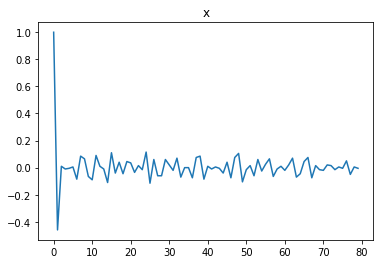

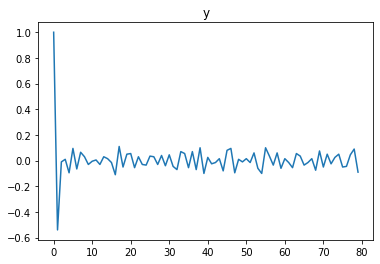

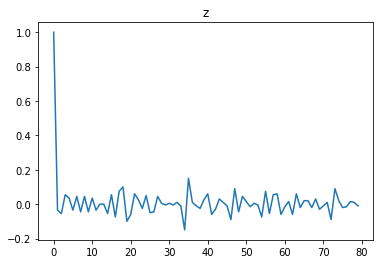

In [49]:
for j in ['x','y','z']:
    plt.figure()
    plt.plot(Cs[j][0,:])
    plt.title(j)
#plt.legend(['x','y','z'])
    plt.show()
    